In [ ]:
%matplotlib inline

# Optimization
One of the main applications of **CADET-Process** is performing optimization studies. 
Optimization refers to the selection of a solution with regard to some criterion.
In the simplest case, an optimization problem consists of minimizing some function $f(x)$ by systematically varying the input values $x$ and computing the value of that function.

$$
\min_x f(x)
$$


In the context of physico-chemical processes, examples for the application of optimization studies include scenarios such as process optimization and parameter estimation.
Here, often many variables are subject to optimization, multiple criteria have to be balanced, and additional linear and nonlinear constraints need to be considered.

$$
\min_x f(x) \\
s.t. \\
    g(x) \le 0, \\
    h(x) = 0, \\
    x \in \mathbb{R}^n \\
$$


where $g$ summarizes all inequality constraint functions, and $h$ equality constraints.

In the following, the optimization module of CADET-Process is introduced.
To decouple the problem formulation from the problem solution, two classes are provided:
And an abstract Optimizer interface class which allows using different external optimizers to solve the problem.

## Example 1: Minimization of a quadratic function

Usually, the objective function is not known; it can only be evaluated at certain points.
For demonstration purpouses, consider a quadratic function to be minimized.

$$
f(x) = x^2
$$

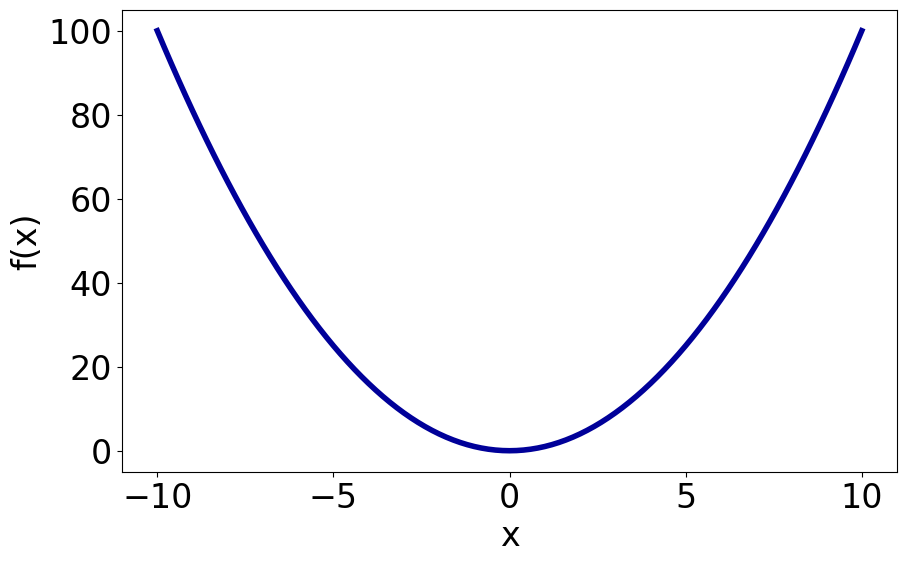

Since we already know a lot about this function, it can help to introduce some of the Optimization concepts of CADET-Process.
For example, the results should yield:
- $x_{opt} = 0$
- $f_{opt} = 0$.

### OptimizationProblem

The `OptimizationProblem` class is is used to specify optimization variables, objectives and constraints.
After import, the `OptimizationProblem` initialized with a name.

In [ ]:
from CADETProcess.optimization import OptimizationProblem

optimization_problem = OptimizationProblem('quadratic')

#### Optimization Variables
Any number of variables can be added to the `OptimizationProblem`.
To add a variable, use the `add_variable` method.
In this case, there is only a single variable.
The first argument is the name of the variable.
Moreover, lower and upper bounds can be specified.


In [ ]:
optimization_problem.add_variable(name='x', lb=-10, ub=10)

### Objectives
Any `callable` (i.e. an object that can be called using the `( )` operator) can be added as an objective as long as it takes x as the first (and only) argument
Note that usually there are multiple variables involved.
Hence, the x that is passed internally is a list.

Multi-objective optimization is also possible with CADET-Python (more on that later).
For now, the objective must return a single, scalar value.

In [ ]:
def objective_fun(x):
    return x[0]**2

optimization_problem.add_objective(objective_fun)

To evaluate the this function, the `evaluate_objective` method can be used.
This is useful to test whether everything works as expected.

In [ ]:
print(optimization_problem.evaluate_objectives([2]))
print(optimization_problem.evaluate_objectives([0]))
print(optimization_problem.evaluate_objectives([-2]))

If the value is out of bounds, an error will be thrown.

In [ ]:
# print(optimization_problem.evaluate_objectives([11]))

### Initial Values

To start solving any optimization problem, initial values are required.
In CADET-Process, this can be done automatically if
- all variables have bounds
- no linear equality constraints exist.

To create initial values, call `create_initial_values` and specify the number of individuals that should be returned.
values.
By default, a random value is returned which fulfills bound and linear constraints.
By specifying `method='chebyshev'`, the so-called Chebyshev center is returned; the center of a minimal-radius ball enclosed by the convex parameter space.
If no information about the location is known, this can be a good starting point.

In [ ]:
x0 = optimization_problem.create_initial_values()
print(x0)

In [ ]:
x0 = optimization_problem.create_initial_values(method='chebyshev')
print(x0)

For population based algorithms such as genetic algorithm, an entire population is required.
Because efficiently sampling a convex polytope can be difficult, we make use  of [hopsy](https://modsim.github.io/hopsy/index.html), a tool for Markov chain Monte Carlo sampling on convex polytopes.

In [ ]:
x0 = optimization_problem.create_initial_values(10)
print(x0)

For this example, the starting value $x_0 = 2$ is specified manually.

In [ ]:
optimization_problem.x0 = [2]

### Optimizer
The `OptimizerAdapter` provides a unified interface for using external optimization libraries.
It is responsible for converting the `OptimizationProblem` to the specific API of the external `Optimizer`.
Currently, adapters to **Pymoo** and **Scipy's** optimization suite are implemented, all of which are published under open source licenses that allow for academic as well as commercial use.

Before the optimization can be run, the `Optimizer` needs to be initialized and configured.
For this example, `NelderMead` is used, a genetic algorithm.
All options can be displayed the following way:

In [ ]:
from CADETProcess.optimization import NelderMead

optimizer = NelderMead()
print(optimizer.options)

In [ ]:
optimization_results = optimizer.optimize(optimization_problem)

### Optimization Progress and Results

The `OptimizationResults` which are returned contain information about the progress of the optimization.
For example, the attributes `x` and `f` contain the final value(s) of parameters and the objective function.

In [ ]:
print(optimization_results.x)
print(optimization_results.f)

After optimization, several figures can be plotted to vizualize the results.
For example, the convergence plot shows how the function value changes with the number of evaluations.

In [ ]:
optimization_results.plot_convergence('objectives')

The parameter `space` shows the function values of all evaluated individuals.
Here, lighter color represent later evaluations.
Note that by default the values are plotted on a log scale if they span many orders of magnitude.
To disable this, set `autoscale=False`.

In [ ]:
optimization_results.plot_space(autoscale=False)

Note that more figures are created for constrained optimization, as well as multi-objective optimization.
All figures are also saved automatically in the `working_directory`.
Moreover, results are stored in a `.csv` file.
- The `results_all.csv` file contains information about all evaluated individuals.
- The `results_meta.csv` file contains only the best individuals.

## Example 2: Constrained Optimization

Example taken from [SciPy Documentation](https://docs.scipy.org/doc/scipy/tutorial/optimize.html#id34)

As an example let us consider the constrained minimization of the Rosenbrock function:

$$
\begin{eqnarray*} \min_{x_0, x_1} & ~~100\left(x_{1}-x_{0}^{2}\right)^{2}+\left(1-x_{0}\right)^{2} &\\
    \text{subject to: } & x_0 + 2 x_1 \leq 1 & \\
                        & x_0^2 + x_1 \leq 1  & \\
                        & x_0^2 - x_1 \leq 1  & \\
                        & 2 x_0 + x_1 = 1 & \\
                        & 0 \leq  x_0  \leq 1 & \\
                        & -0.5 \leq  x_1  \leq 2.0. & \end{eqnarray*}
$$

This optimization problem has the unique solution $[x_0, x_1] = [0.4149,~ 0.1701]$.

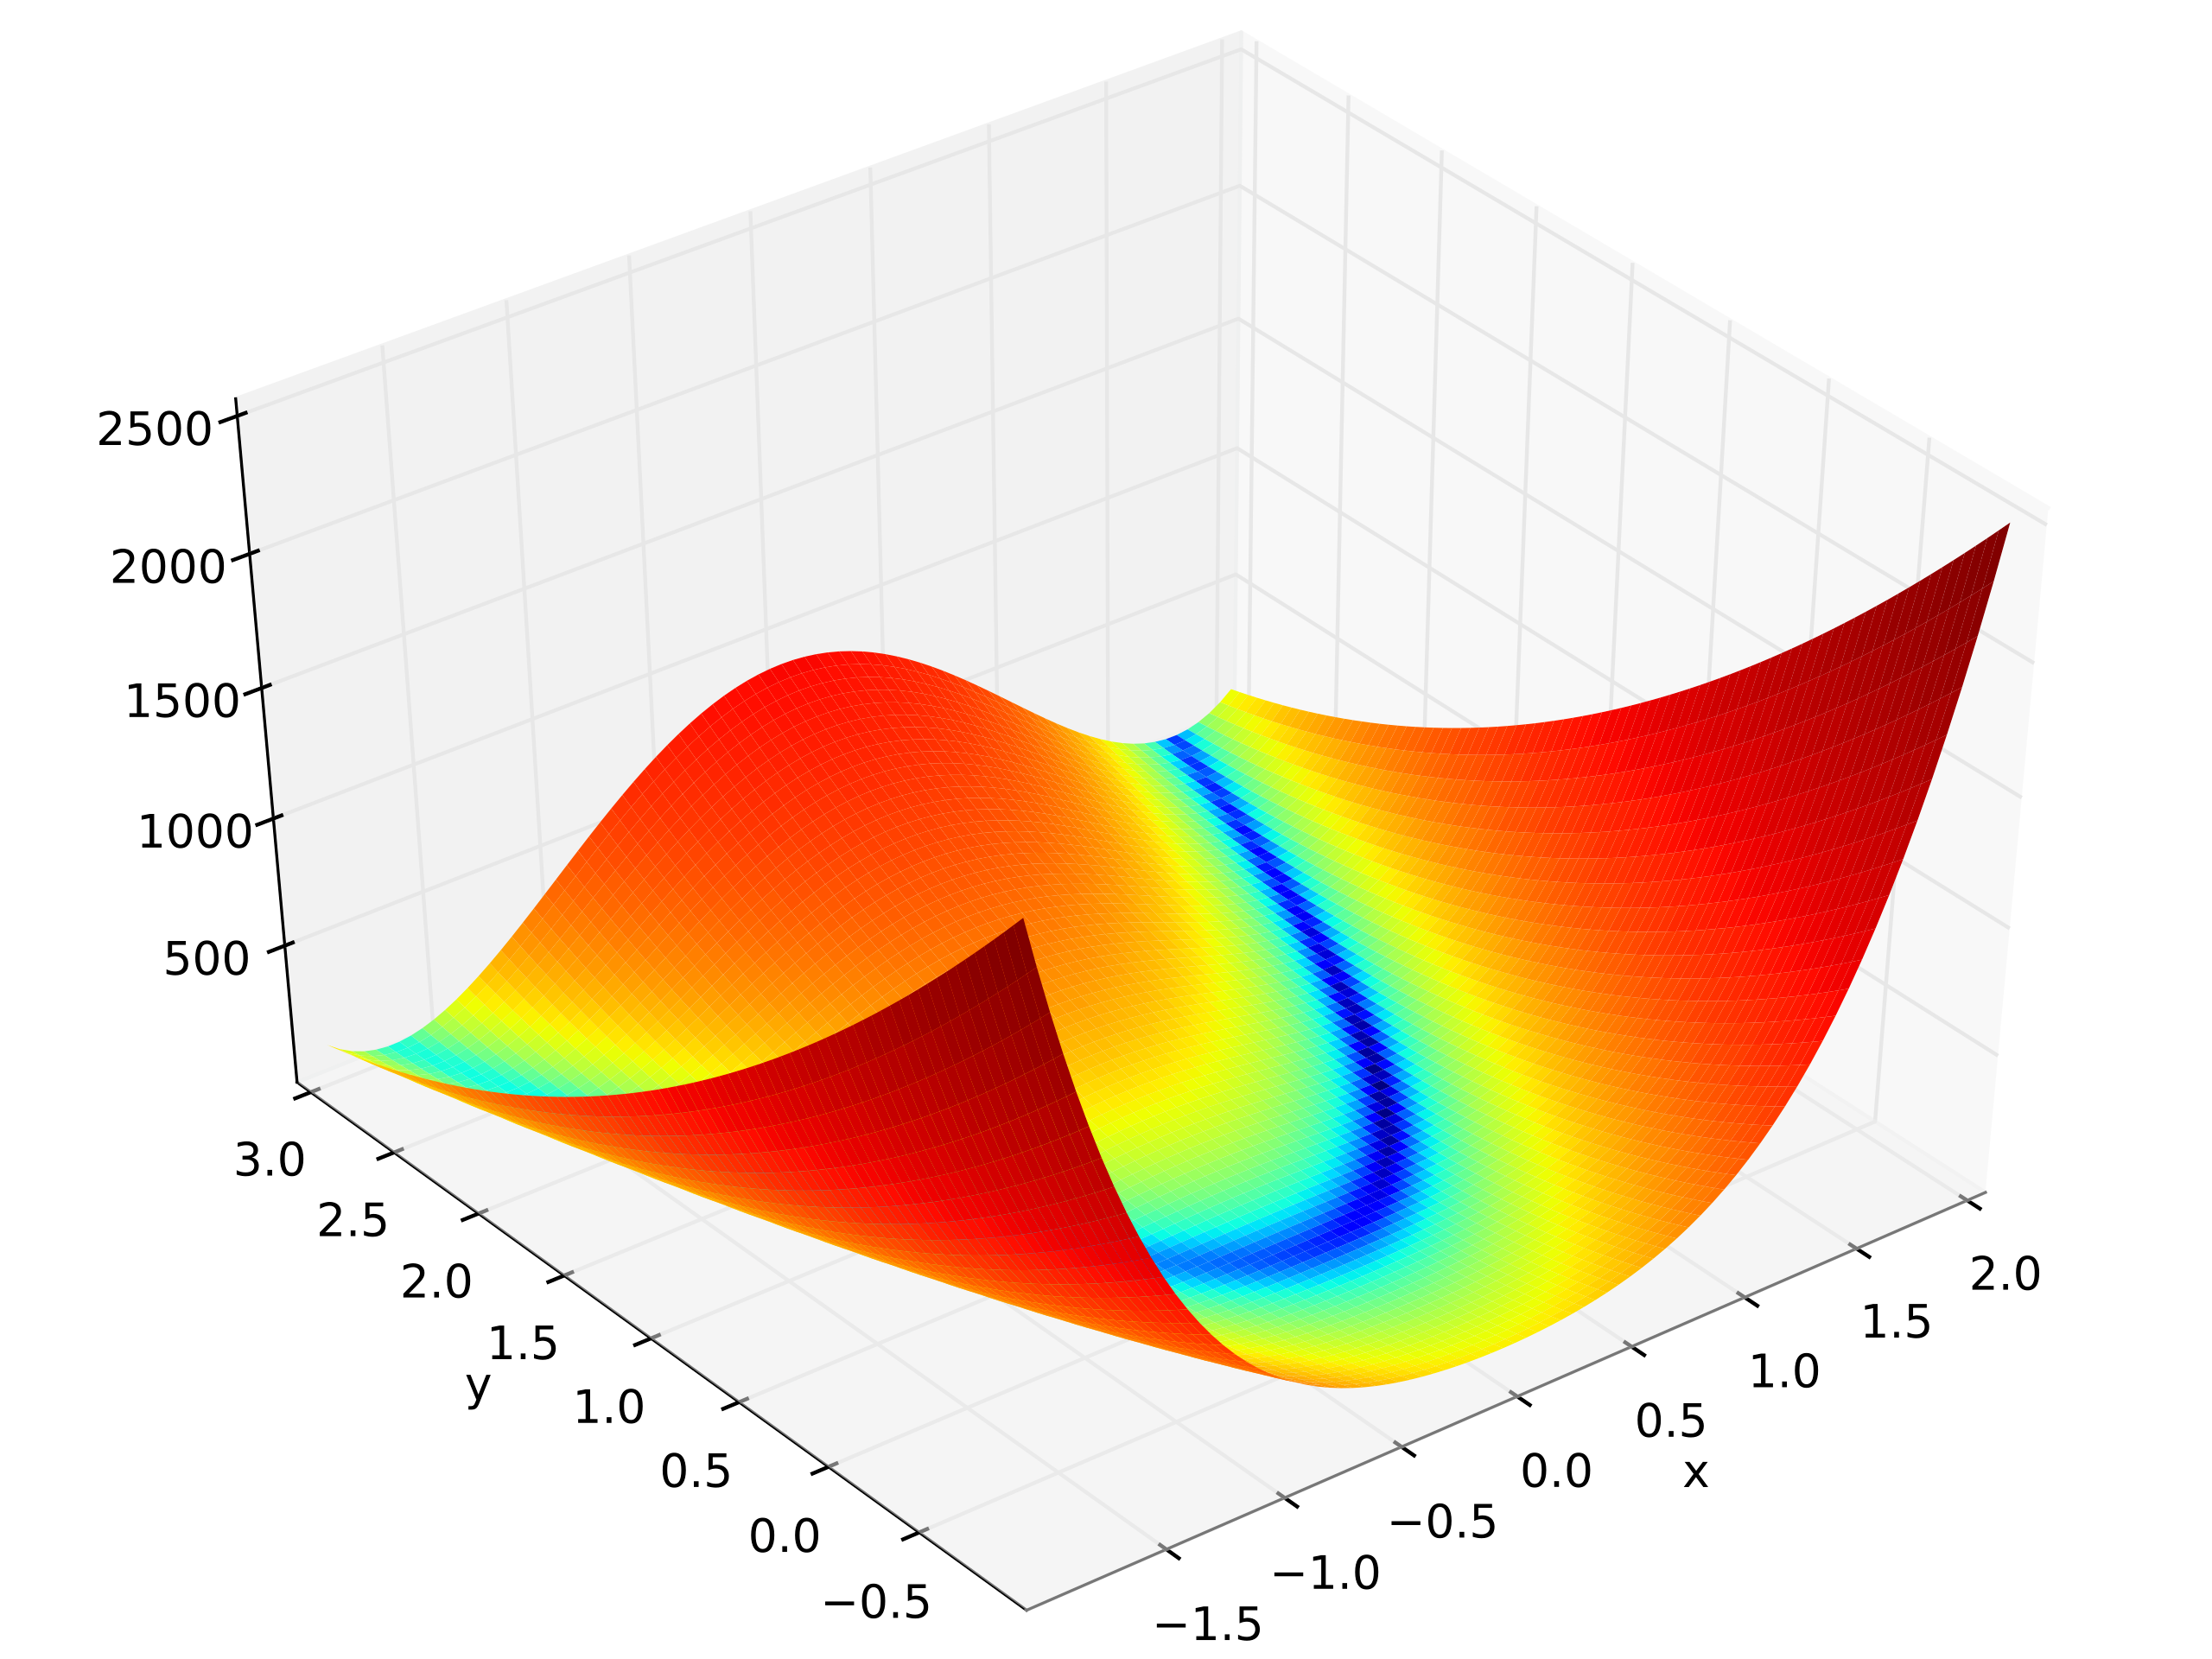

To setup this problem, first a new `OptimizationProblem` is created and the variables are added, including bounds.
It is important to note, that `x0` cannot be used as variable name since it is reserved for the initial values.

In [ ]:
from CADETProcess.optimization import OptimizationProblem

optimization_problem = OptimizationProblem('rosenbrock')

optimization_problem.add_variable('x_0', lb=0, ub=1)
optimization_problem.add_variable('x_1', lb=-0.5, ub=2.0)   

Whether a point is within the bounds can be checked with the `check_bounds` method.
It returns `True` if the point is within bounds and `False` otherwise.
For this example, consider the starting value $x_0 = [0.5, 0]$

In [ ]:
x0 = [0.5, 0]
optimization_problem.x0 = x0
optimization_problem.check_bounds(x0)

### Linear inequality constraints
Linear constraints are usually defined in the following way

$$
A \cdot x \leq b
$$

In **CADET-Process**, add each row $a$ of the constraint matrix needs to be added individually.
The `add_linear_constraint` function takes the variables subject to the constraint as first argument.
The left-hand side $a$ and the bound $b_a$ are passed as second and third argument. 
It is important to note that the column order in $a$ is inferred from the order in which the optimization variables are passed.

To add the constraints of the Rosenbrock function to the optimization problem, add the following:

In [ ]:
optimization_problem.add_linear_constraint(['x_0', 'x_1'], [1, 2], 1)

To wheck if a point fulfils the linear inequality constraints, use the `check_linear_constraints` method.
It returns `True` if the point is within bounds and `False` otherwise.

In [ ]:
optimization_problem.check_linear_constraints(x0)

### Linear equality constraints
Linear equality constraints are usually defined in the following way

$$
A_{eq} \cdot x = b_{eq}
$$

In **CADET-Process**, add each row $a_{eq}$ of the constraint matrix needs to be added individually.
The `add_linear_equality_constraint` function takes the variables subject to the constraint as first argument.
The left-hand side $a_{eq}$ and the bound $b_{eq, a}$ are passed as second and third argument. 
It is important to note that the column order in $a$ is inferred from the order in which the optimization variables are passed.

To add the constraints of the Rosenbrock function to the optimization problem, add the following:

In [ ]:
optimization_problem.add_linear_equality_constraint(['x_0', 'x_1'], [2, 1], 1)

To wheck if a point fulfils the linear equality constraints, use the `check_linear_equality_constraints` method.
It returns `True` if the point is within bounds and `False` otherwise.

In [ ]:
optimization_problem.check_linear_equality_constraints(x0)

### Nonlinear constraints
Moreover, nonlinear constraints can be added to the `OptimizationProblem`.

$$
g(x) \le 0 \\
$$

In contrast to linear constraints, and analogous to objective functions, nonlinear constraints need to be added as a callable functions.
Note that multiple nonlinear constraints can be added.
In addition to the function, lower or upper bounds can be added.

To add the constraints of the Rosenbrock function to the optimization problem, add the following.

In [ ]:
def nonlincon_1(x):
    x_0 = x[0]
    x_1 = x[1]

    return x_0**2 + x_1


optimization_problem.add_nonlinear_constraint(nonlincon_1, bounds=[1])


def nonlincon_2(x):
    x_0 = x[0]
    x_1 = x[1]

    return x_0**2 - x_1

optimization_problem.add_nonlinear_constraint(nonlincon_2, bounds=[1])

Again, the function can be evaluated manually.

In [ ]:
optimization_problem.check_nonlinear_constraints(x0)

Then, then objective function is defined and added.

In [ ]:
def objective(x):
    x_0 = x[0]
    x_1 = x[1]
    
    return 100 * (x_1 - x_0**2)**2 + (1 - x_0)**2

optimization_problem.add_objective(objective)

### Optimizer
To solve this problem, the **Nelder-Mead** algorithm previously cannot be used since it does not support constraints.
Instead, here a **trust region method** is used.

In [ ]:
from CADETProcess.optimization import TrustConstr

optimizer = TrustConstr()

optimization_results = optimizer.optimize(
    optimization_problem,
)

### Optimization Progress and Results

Since in this problem, nonlinear constraints are involved, their convergence can also be plotted

In [ ]:
optimization_results.x

In [ ]:
optimization_results.plot_convergence('objectives')
optimization_results.plot_convergence('nonlinear_constraints')

___